In [1]:
import os
os.chdir("..")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

from SSTImportanceSampling  import Preprocessor, ImportanceSampler, StormDepthProcessor, AdaptParams, AdaptiveMixtureSampler

from production.utils import summarize_depths_by_return_period
from production.metrics import metrics
from production.plots import plot_return_period_summary, plot_two_return_period_summaries
from production.plots import plot_adaptive_evolution


In [3]:
watershed_names = ["Trinity","Kanawha","Duwamish","Denton"]

In [4]:
#Load data
watersheds = {}

for wname in watershed_names:
    ws = Preprocessor.load(
        config_path=f"/workspaces/Importance-Sampling-for-SST/data/1_interim/{wname}/config.json"
    )
    watersheds[wname] = ws

In [ ]:
#Full Monte Carlo summary
base_dir = "/workspaces/Importance-Sampling-for-SST/data/2_production"
summary_filename = "fullmonte_summary.pq"

# --- load summaries ---
summaries = {}
for w in watershed_names:
    path = os.path.join(base_dir, w, summary_filename)
    df = pd.read_parquet(path)
    needed = {"RP","median_in","ci95_low_in","ci95_high_in"}
    if not needed <= set(df.columns):
        raise ValueError(f"{w}: summary missing columns {needed - set(df.columns)}")
    summaries[w] = df.sort_values("RP")

In [6]:
watershed = watersheds["Trinity"]

In [7]:
params = AdaptParams(
    mu_x_n=watershed.watershed_stats["x"],
    mu_y_n=watershed.watershed_stats["y"],
    sd_x_n=watershed.watershed_stats["range_x"] * 0.5,
    sd_y_n=watershed.watershed_stats["range_y"] * 0.5,

    mu_x_w=watershed.watershed_stats["x"],
    mu_y_w=watershed.watershed_stats["y"],
    sd_x_w=watershed.domain_stats["range_x"],
    sd_y_w=watershed.domain_stats["range_y"],

    rho_n=-0.7,      # correlation narrow
    rho_w=0.5,       # correlation wide
    mix=0.5,         # initial mixture weight for narrow
)

sampler = AdaptiveMixtureSampler(
    data=watershed,                   
    params=params,
    precip_cube=watershed.cumulative_precip,
    seed=42
)

# Adapt does NOT take data or seed
history = sampler.adapt(num_iterations=10, samples_per_iter=1000)

In [8]:
history

,iter,n,ess,hit_raw,hit_w,updated,mix,mu_x_n,mu_y_n,sd_x_n,sd_y_n,rho_n
0,0,NaN,NaN,NaN,NaN,0,0.500000,-47423.503597,1.019272e+06,196733.000007,222234.350353,-0.700000
1,1,1000.0,638.852725,1.0,0.999999,1,0.650000,97869.206835,9.587286e+05,296315.998741,196738.737805,-0.037915
2,2,1000.0,826.929169,1.0,0.999999,1,0.754999,98083.022004,9.411008e+05,301290.289317,187016.991447,0.117027
3,3,1000.0,762.726064,1.0,0.999999,1,0.828499,113882.764012,9.483785e+05,310585.787964,185879.163392,0.164791
4,4,1000.0,772.510724,1.0,0.999999,1,0.879949,105092.849885,9.474521e+05,297796.825515,193118.152909,0.178329
5,5,1000.0,635.395914,1.0,0.999999,1,0.915964,120566.505791,9.251349e+05,311088.285885,185609.108565,0.195783
6,6,1000.0,683.637635,1.0,0.999999,1,0.941175,113178.327467,9.308987e+05,298092.711972,184775.561700,0.197783
7,7,1000.0,749.990881,1.0,0.999999,1,0.950000,112523.013568,9.341829e+05,292232.306018,187604.448090,0.197022
8,8,1000.0,688.199713,1.0,0.999999,1,0.950000,106889.307067,9.282485e+05,289209.373822,185245.927531,0.187093
9,9,1000.0,790.111769,1.0,0.999999,1,0.950000,98785.203048,9.283216e+05,274764.507555,183337.257184,0.139610


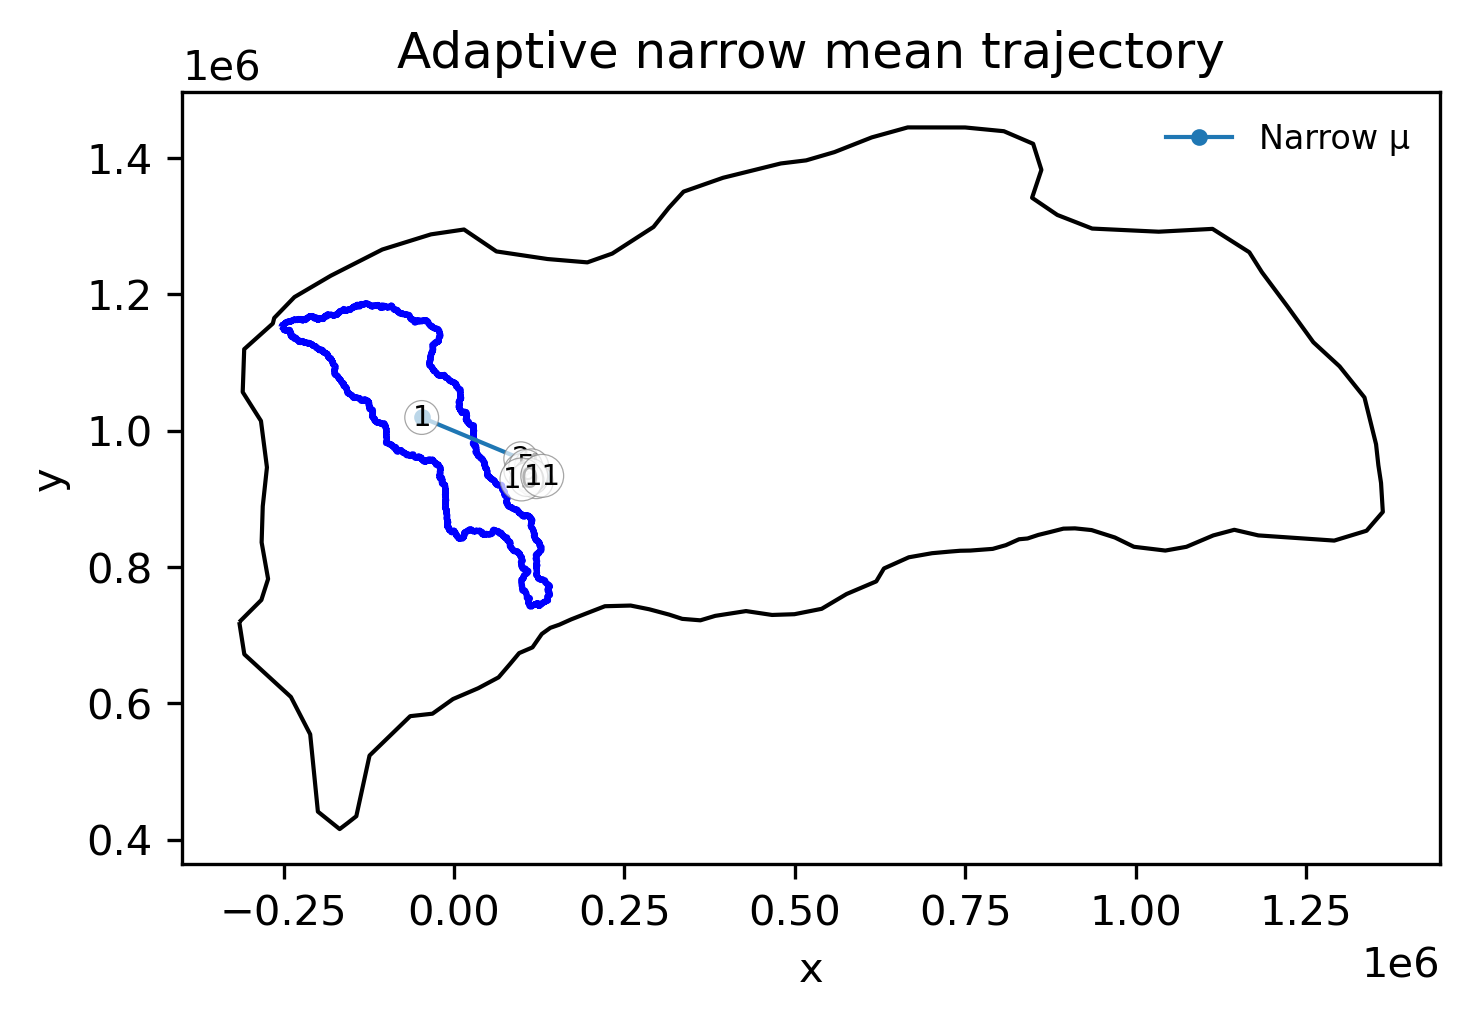

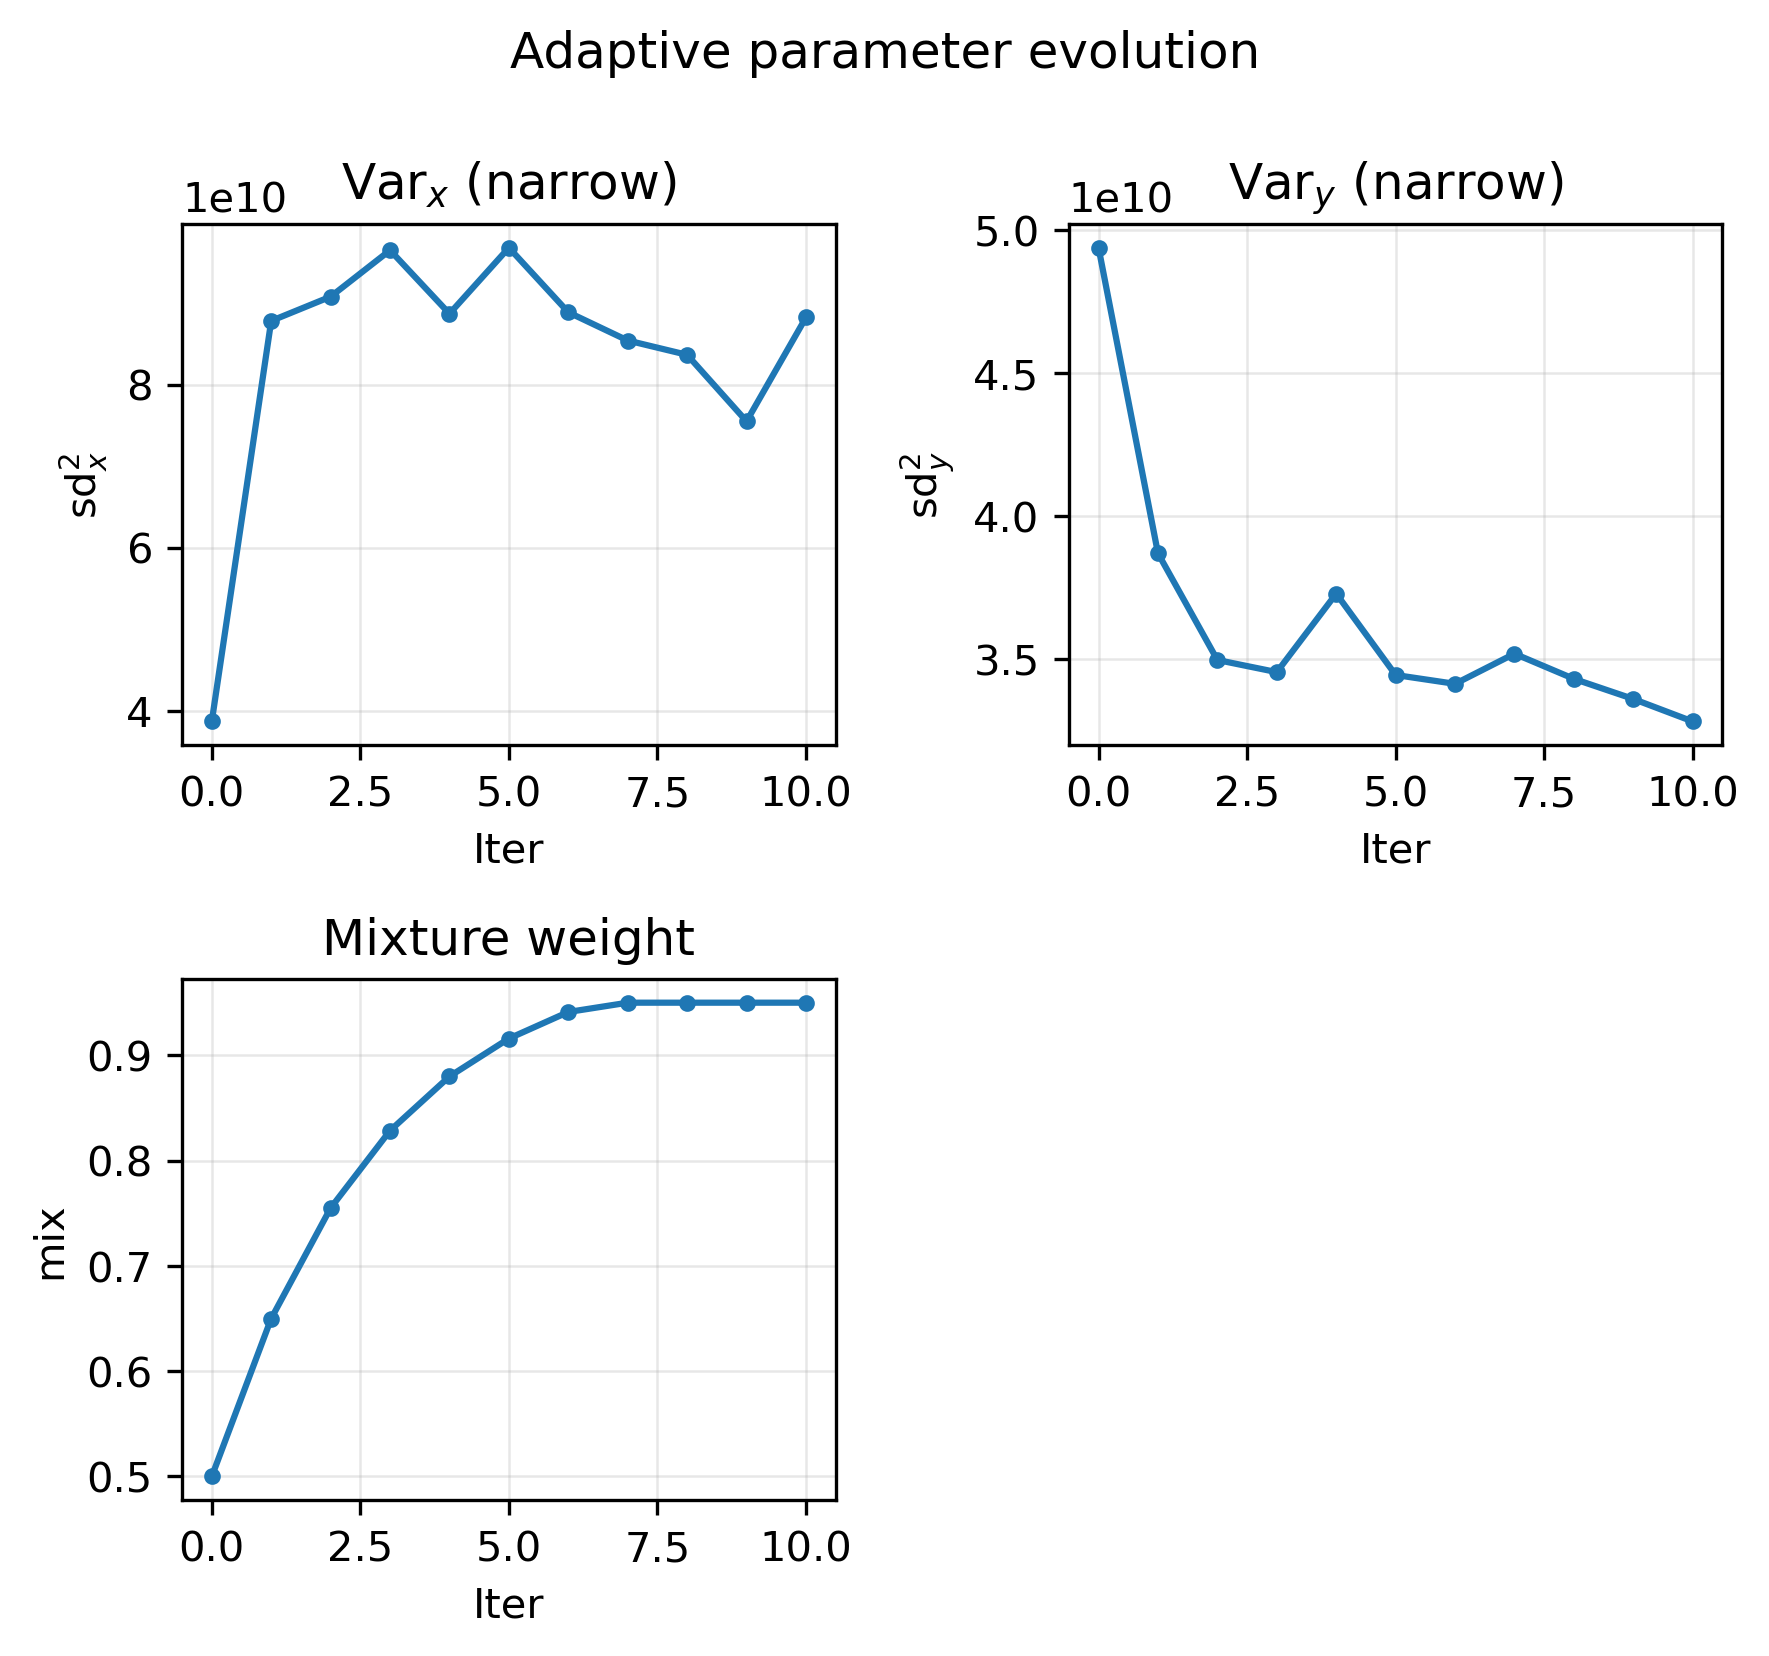

In [9]:
plot_adaptive_evolution(history, watershed.watershed_gdf, watershed.domain_gdf, save=False, prefix="trinity_ais")

In [13]:
final_df = sampler.sample_final(n=6000, num_realizations=50, with_depths=True)

In [14]:
final_df

,realization,realization_seed,event_id,storm_path,x,y,newx,newy,delx,dely,weight_raw,weight,precip_avg_mm,exc_prb
0,1,3.525229e+18,1,19890327_72hr_st1_r308,114000.0,1014000.0,-101046.535275,9.735487e+05,-215046.535275,-40451.321602,0.998191,0.000165,38.868328,0.638425
1,1,3.525229e+18,2,19910128_72hr_st1_r290,638000.0,826000.0,218953.464725,8.255487e+05,-419046.535275,-451.321602,0.484781,0.000080,43.925564,0.441875
2,1,3.525229e+18,3,20091012_72hr_st5_r078,226000.0,1142000.0,-29046.535275,1.093549e+06,-255046.535275,-48451.321602,0.836028,0.000138,56.864735,0.183963
3,1,3.525229e+18,4,20200218_72hr_st1_r296,1018000.0,1178000.0,202953.464725,1.021549e+06,-815046.535275,-156451.321602,0.516860,0.000085,49.315044,0.313237
4,1,3.525229e+18,5,20040608_72hr_st2_r124,-242000.0,786000.0,-261046.535275,8.135487e+05,-19046.535275,27548.678398,1.069692,0.000176,33.044548,0.813396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,50,1.568048e+19,5996,20090417_72hr_st1_r413,-98000.0,734000.0,-201046.535275,6.815487e+05,-103046.535275,-52451.321602,1.287269,0.000212,43.845146,0.443037
299996,50,1.568048e+19,5997,19911028_72hr_st5_r092,618000.0,838000.0,-13046.535275,7.495487e+05,-631046.535275,-88451.321602,0.693604,0.000114,45.684788,0.393372
299997,50,1.568048e+19,5998,20180528_72hr_st5_r148,878000.0,1110000.0,234953.464725,9.495487e+05,-643046.535275,-160451.321602,0.632935,0.000104,37.520962,0.666366
299998,50,1.568048e+19,5999,20170402_72hr_st1_r244,1226000.0,858000.0,270953.464725,7.495487e+05,-955046.535275,-108451.321602,0.323062,0.000053,44.118408,0.435216


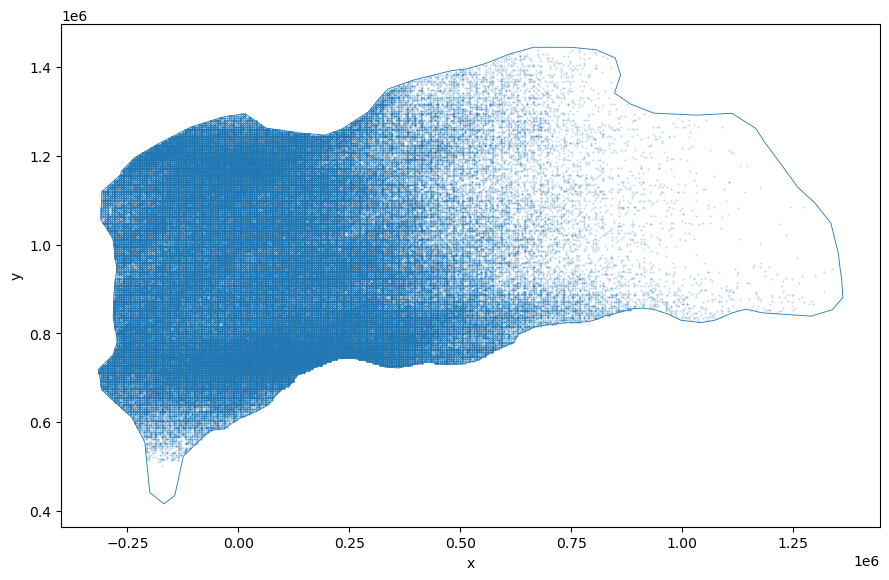

In [15]:
ax = watershed.domain_gdf.boundary.plot(linewidth=0.6, figsize=(9,9))
plt.scatter(final_df.newx, final_df.newy, s=0.2, alpha=0.3, rasterized=True)
plt.gca().set_aspect("equal")
plt.xlabel("x"); plt.ylabel("y"); plt.tight_layout()
plt.show()

In [19]:
adaptive_summary = summarize_depths_by_return_period(
    df=final_df,       
    precip_col="precip_avg_mm",
    exc_col="exc_prb",
    realization_col="realization",
    k=10.0,                            
    rp_min=2,
    rp_max_cap=2000,
)

In [22]:
m = metrics(summaries["Trinity"],adaptive_summary)
m

,n_points,rp_min_used,rp_max_used,rmse_mean,rmse_median,rmse_ci95_low,rmse_ci95_high,rmse_ci90_low,rmse_ci90_high,me_mean,...,me_ci95_low,me_ci95_high,me_ci90_low,me_ci90_high,diff_at_maxrp_mean,diff_at_maxrp_median,diff_at_maxrp_ci95_low,diff_at_maxrp_ci95_high,diff_at_maxrp_ci90_low,diff_at_maxrp_ci90_high
0,424,2.0,425.0,3.478624,3.478644,3.285368,3.664318,3.321287,3.646313,-3.423064,...,-3.234108,-3.604987,-3.26833,-3.586535,-3.952267,-3.963332,-3.727876,-4.057021,-3.791594,-4.072255


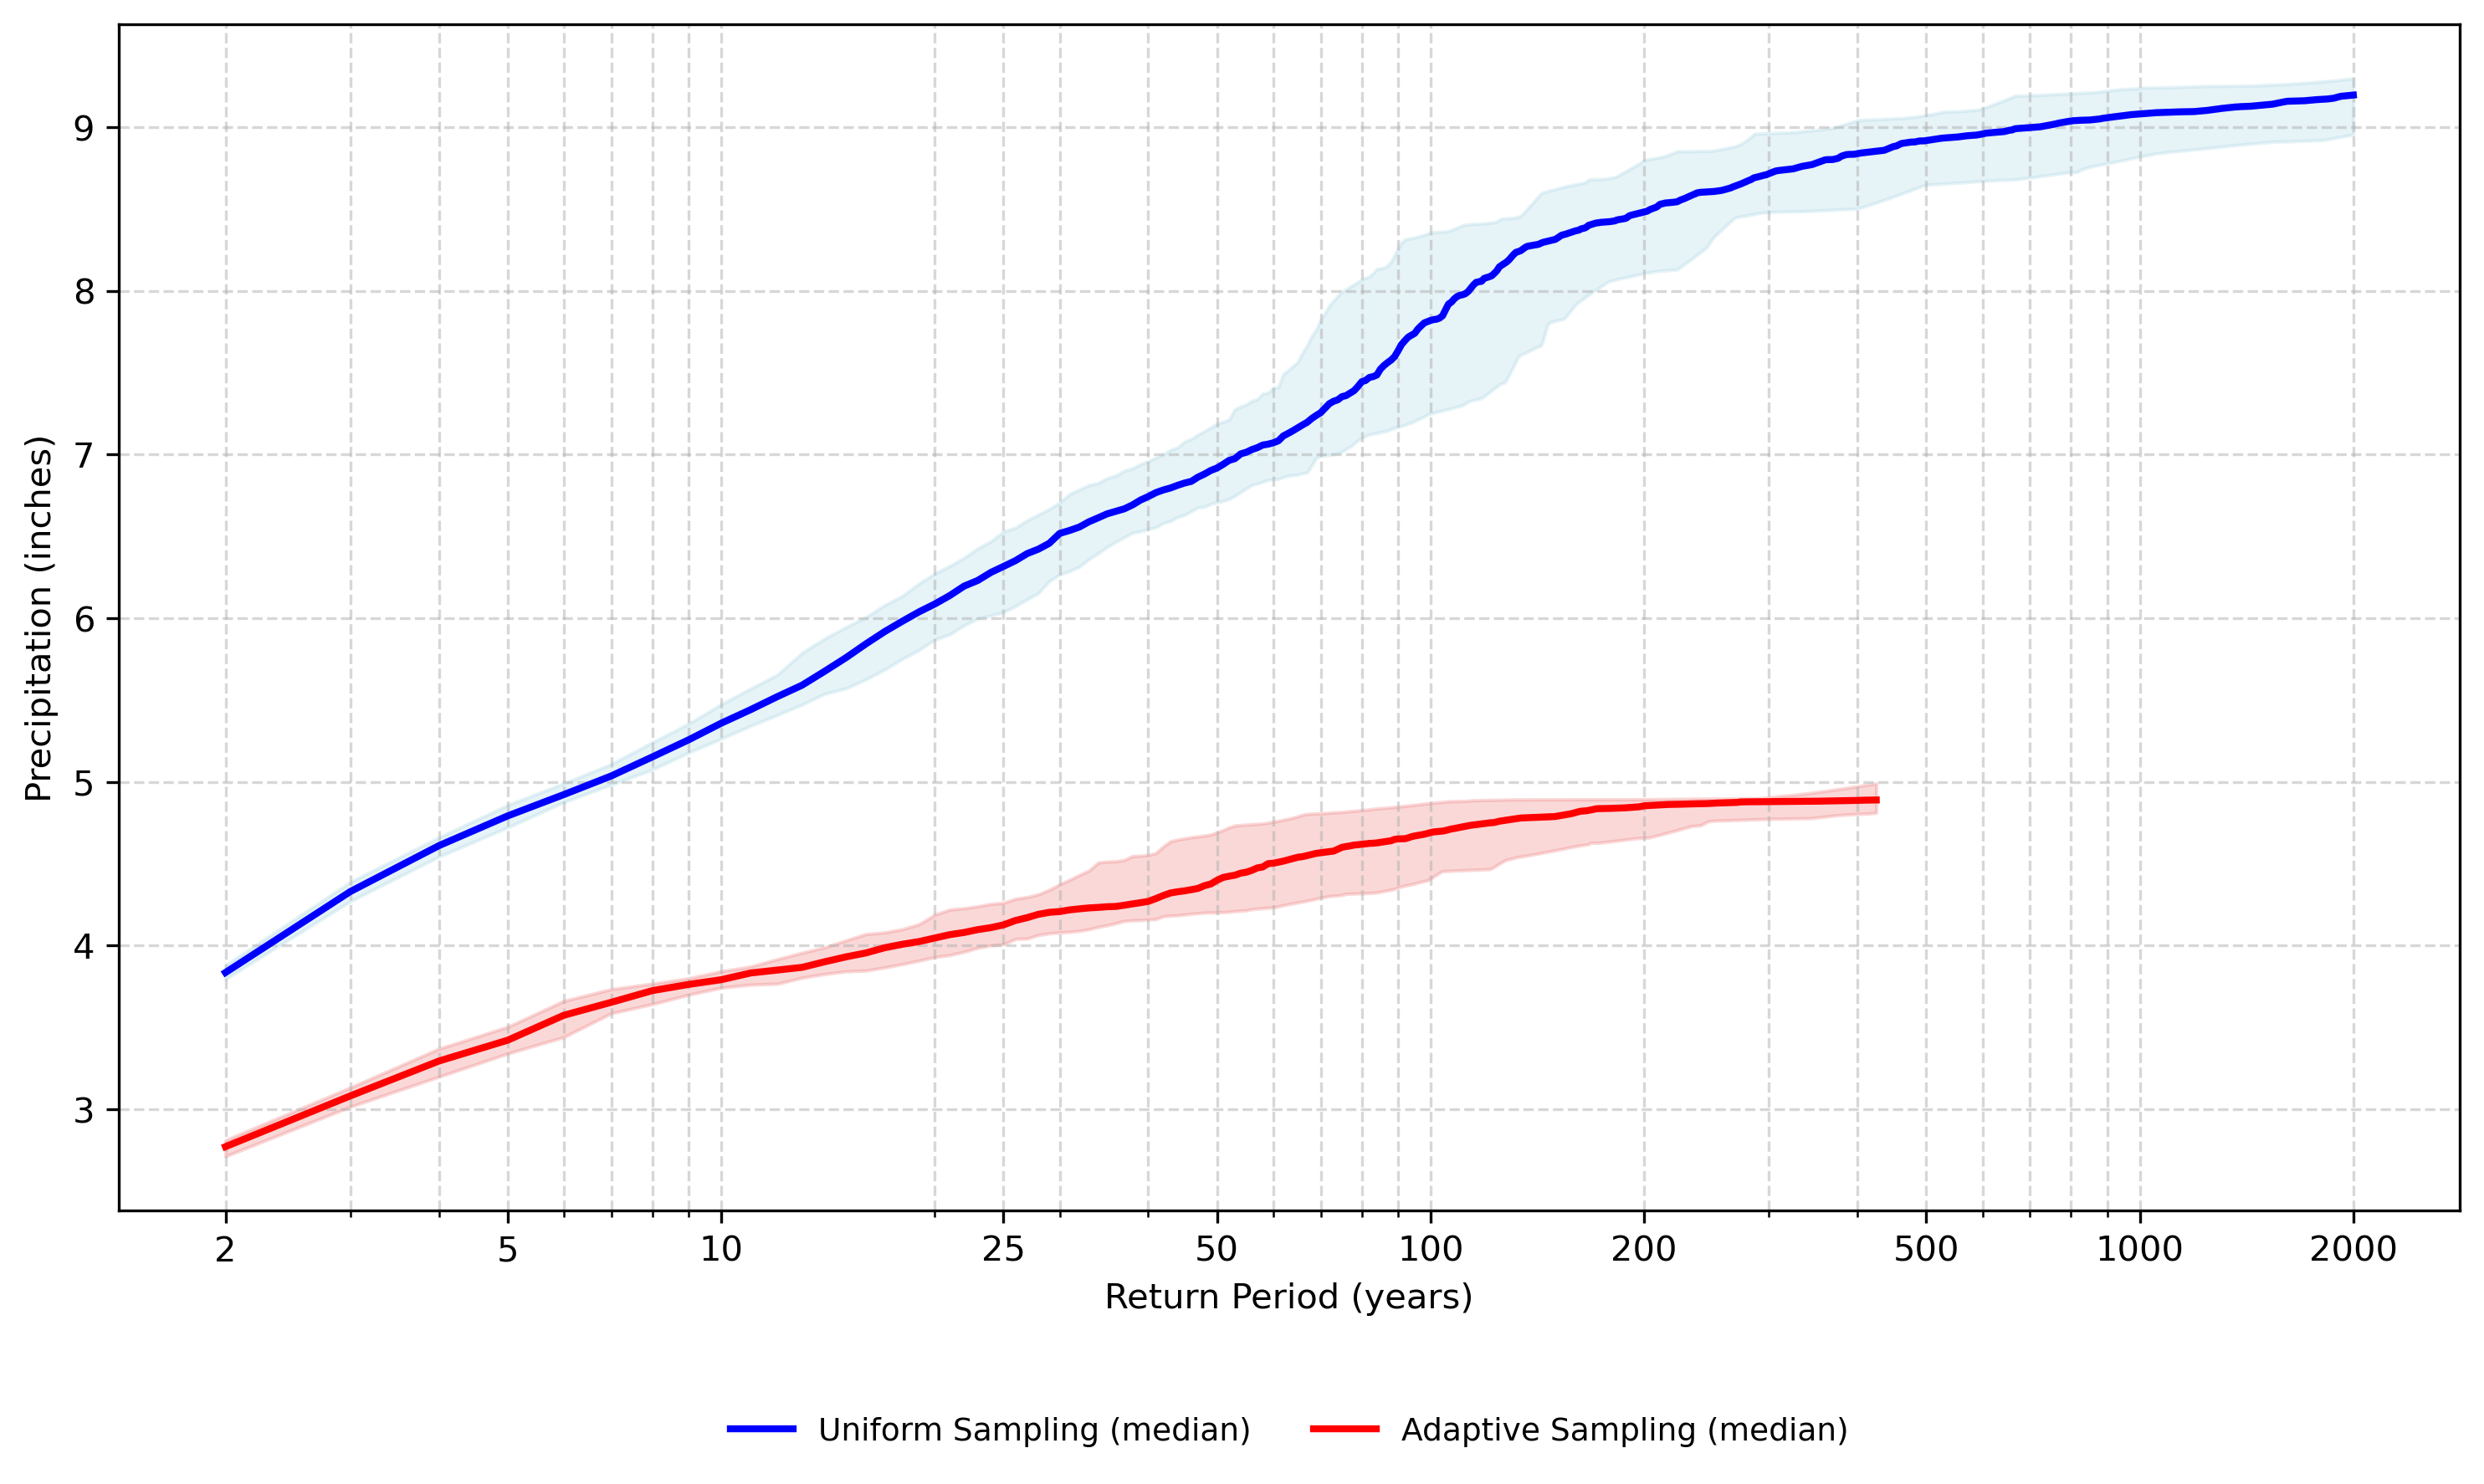

In [24]:
plot_two_return_period_summaries(
    summary1= summaries["Trinity"],          # your first summary DataFrame
    summary2=adaptive_summary,       # your second summary DataFrame
    label1="Uniform Sampling",
    label2="Adaptive Sampling",
    title=""
)